Command line code to populate olist database:

```psql -f setup_olist.sql```

What is my goal here?

Trying to predict what will cause a late shipment (can't use any data for prediction that would come after the shipment of the product itself)

https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_customers_dataset.csv

Can add a Flask app - using predictor_app.py by using their template on the Flask app. Not a big deal to run your website on your own computer, and then take a video of your dashboard with your project.

I can put sliders on a website to predict how likely a shipment is to be late. (Ex: Sliders with lat/long distance from buyer to seller, along with product price, freight_value

### Jonathan recommends testing preliminarily with one model vs the other (SVM vs Random Forest, for instance). Confusion matrix to show the value of false positives vs false negatives (Type I vs Type II Errors). Then improve your model and show, on the next slide, which optimized model "won", and why.

In [308]:
import numpy as np
import pandas as pd
import pandas_profiling # Use pandas_profiling.ProfileReport(df) instead of df.describe()
import matplotlib.pyplot as plt

%matplotlib inline

from psycopg2 import connect

In [81]:
params = {
    'host': 'localhost',
    'user': 'alexandrezajic',
    'port': 5432
}

connection = connect(**params, dbname='olist')
cursor = connection.cursor()

In [19]:
7827 / (7827 + 91614)

0.07870998883760219

~7.9% of deliveries were delivered late, according to my math above (data comes from deleted preliminary olist read_csv and comparison of delivery dates to estimated dates)

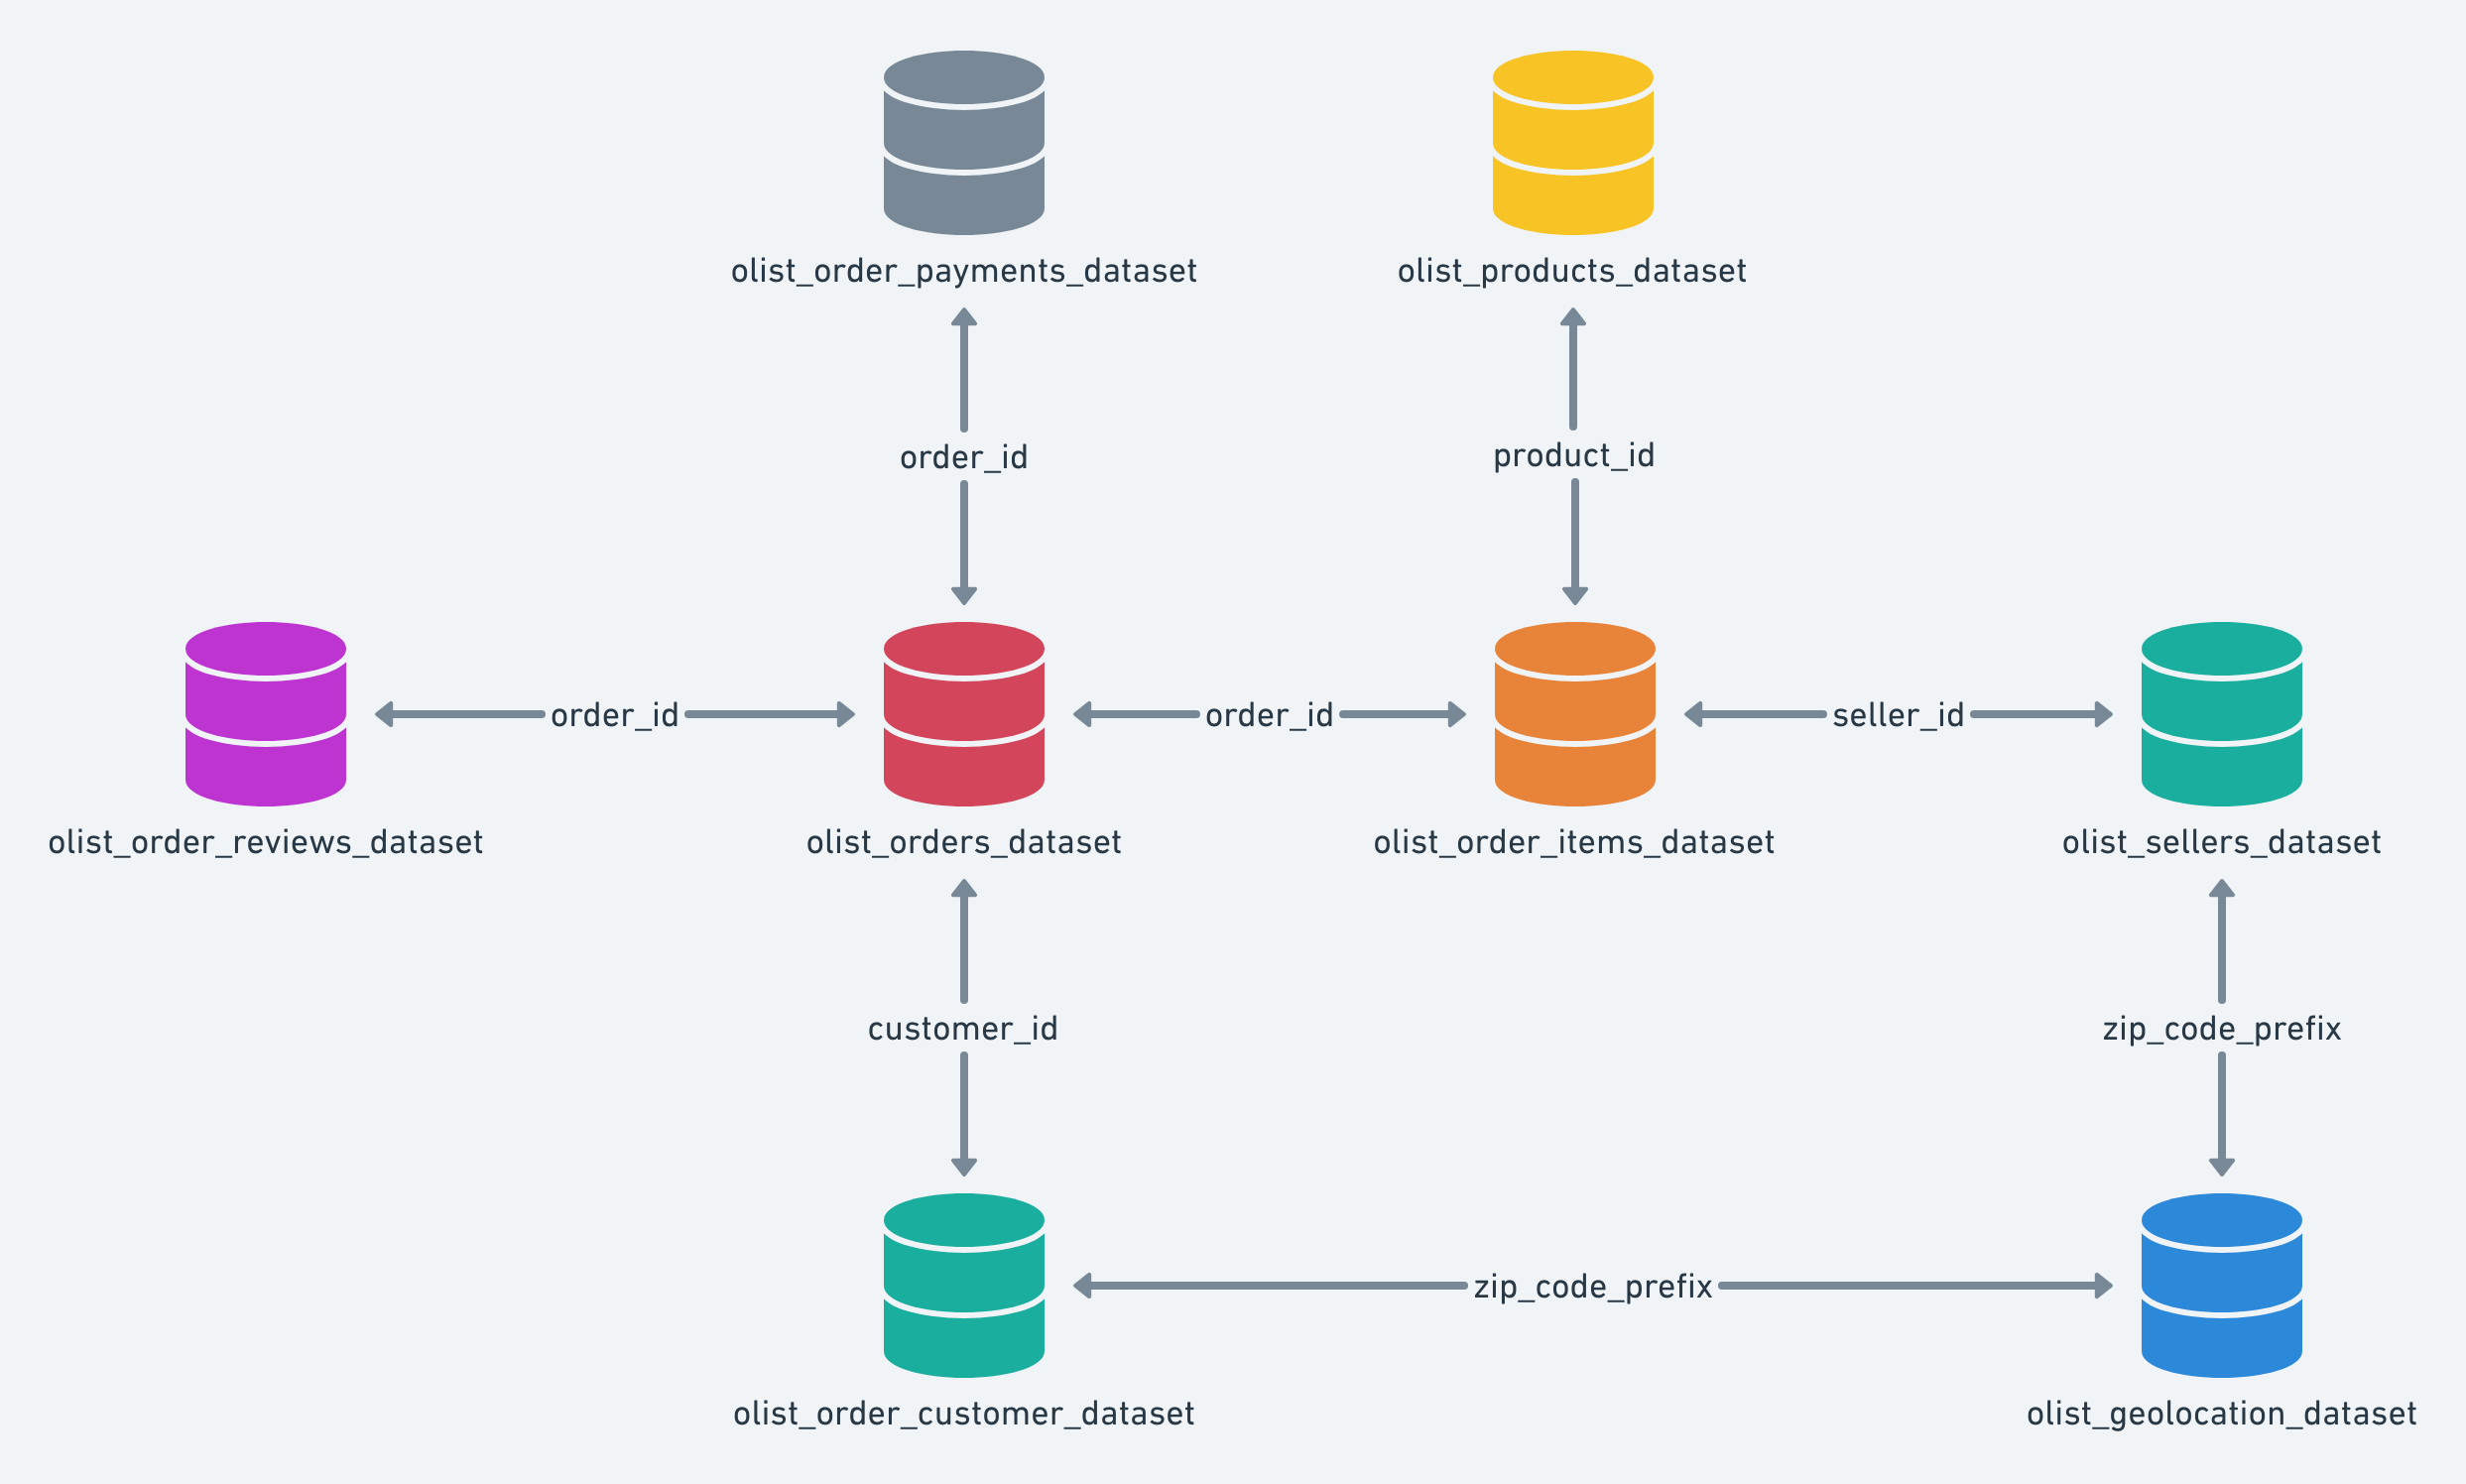

## What features do I care about? What needs to be grouped together?

Features:

1. Customers: customer_zip_code_prefix /// customer_city /// customer_state
2. Geolocation: /// geolocation_lat /// geolocation_lng /// (is this the same as customer_city or customer_state?)
3. Order_Items: /// **shipping_limit_date** /// **price** /// **freight_value** /// (what is the difference between price and freight_value?)
4. Payments: N/A (after shipment)
5. Order_Reviews: N/A (after shipment)
6. Orders: /// order_id /// customer_id /// order_purchase_timestamp /// order_approved_at /// order_delivered_carrier_date /// **order_delivered_customer_date** /// **order_estimated_delivery_date** /// (Last 2 useful for deriving whether a delivery was late. Earlier timestamps may be used to predict a pattern of late delivery - for instance if the ∆ between purchase timestamp and approval timestamp is wide)
7. Products: /// product_category_name /// product_weight_g /// product_length_cm /// product_height_cm /// product_width_cm /// (Can derive volume from the dimensions)
8. Sellers: /// seller_zip_code_prefix /// seller_city /// seller_state (can be compared with customers)
9. OPTIONAL Product_Category_Name_Translation: (If product category is predictive and needs to be translated to English) /// product_category_name /// product_category_name_english

## 1. Geolocation -> Customers -> Orders

I need to get the latitude and longitude data for customers, and merge that into orders

In [35]:
geolocation = pd.read_sql('''
SELECT
  g.geolocation_lat customer_lat, g.geolocation_lng customer_long, g.geolocation_city, g.geolocation_state,
  g.geolocation_zip_code_prefix
FROM geolocation g
''', connection)

geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
customer_lat                   1000163 non-null float64
customer_long                  1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
geolocation_zip_code_prefix    1000163 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [37]:
# We can see from this that each zip code may have many many lat/longs.
# I'll just take the first lat/long I see as the zip code's lat/long measurement
print(geolocation['geolocation_zip_code_prefix'].value_counts(), geolocation.shape)

24220    1146
24230    1102
38400     965
35500     907
11680     879
22631     832
30140     810
11740     788
38408     773
28970     743
36400     733
39400     724
37701     714
35162     713
35900     709
37200     696
88330     694
22790     687
35700     678
36570     667
38600     654
30575     652
20550     646
41830     641
29101     631
37550     621
29090     615
38610     614
24210     607
11250     602
         ... 
83760       1
55042       1
35593       1
49920       1
57604       1
70666       1
15905       1
31785       1
18216       1
78087       1
35133       1
33084       1
36666       1
55600       1
32553       1
40245       1
11555       1
36148       1
87567       1
70406       1
38455       1
18218       1
40241       1
45104       1
20776       1
73990       1
87307       1
72450       1
24877       1
38198       1
Name: geolocation_zip_code_prefix, Length: 19015, dtype: int64 (1000163, 5)


In [87]:
cursor.execute('''
SELECT
  (MAX(g.geolocation_lat) - MIN(g.geolocation_lat)) AS result
FROM geolocation g
WHERE g.geolocation_zip_code_prefix = 24220''')

In [88]:
# From here I can see that the difference between the max and min lat within any latitude is negligible,
# meaning that I can probably just choose the first lat/long in the dataset for each zip code
cursor.fetchall()

[(0.0121188517803255,)]

In [41]:
geolocation.drop_duplicates('geolocation_zip_code_prefix', inplace = True)

In [42]:
geolocation.shape # Much better

(19015, 5)

Since these tables have shown themselves to be messy, rather than following my original plan of coming up with one large SQL query, I'll need to query each of these tables individually, clean them, and then merge inside pandas with pandas functionality.

In [91]:
customers = pd.read_sql('''
SELECT
  c.customer_id, c.customer_zip_code_prefix, c.customer_city, c.customer_state
FROM customers c''', connection)

customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
customer_id                 99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [92]:
pandas_profiling.ProfileReport(customers) # Everything looks good - no warnings of duplicates

Number of variables,4
Number of observations,99441
Total Missing (%),0.0%
Total size in memory,3.0 MiB
Average record size in memory,32.0 B
Numeric,1
Categorical,2
Boolean,0
Date,0
Text (Unique),1
Rejected,0


In [93]:
# Merge only what I need from geolocation. I will drop the geolocation_zip_code_prefix after I merge on it
c_g = customers.merge(geolocation.loc[:,['customer_lat','customer_long', 'geolocation_zip_code_prefix']],
                      how = 'left',
                      left_on = 'customer_zip_code_prefix',
                      right_on = 'geolocation_zip_code_prefix')

c_g.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,geolocation_zip_code_prefix
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-20.509898,-47.397866,14409.0
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,-23.726853,-46.545746,9790.0
2,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo,SP,-23.527788,-46.660310,1151.0
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,mogi das cruzes,SP,-23.496930,-46.185352,8775.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,campinas,SP,-22.987222,-47.151073,13056.0


In [94]:
c_g = c_g.iloc[:,:-1] # I don't need the last column (geolocation_zip_code_prefix)
c_g.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-20.509898,-47.397866
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,-23.726853,-46.545746
2,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo,SP,-23.527788,-46.660310
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,mogi das cruzes,SP,-23.496930,-46.185352
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,campinas,SP,-22.987222,-47.151073


I now have a clean customer dataset with lat/longs, ready to join on my orders dataset

In [61]:
orders = pd.read_sql('''
SELECT
  o.order_id, o.customer_id, o.order_purchase_timestamp, o.order_approved_at, o.order_delivered_carrier_date,
  o.order_delivered_customer_date, o.order_estimated_delivery_date
FROM orders o
''', connection)

orders.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [62]:
orders.info() # Null values - mostly in the delivered date, which is a necessary part of my project

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_purchase_timestamp         99441 non-null datetime64[ns]
order_approved_at                99281 non-null datetime64[ns]
order_delivered_carrier_date     97658 non-null datetime64[ns]
order_delivered_customer_date    96476 non-null datetime64[ns]
order_estimated_delivery_date    99441 non-null datetime64[ns]
dtypes: datetime64[ns](5), object(2)
memory usage: 5.3+ MB


In [65]:
orders.dropna(inplace=True) # Decided to drop all values - not worth investigating small exceptions
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 7 columns):
order_id                         96461 non-null object
customer_id                      96461 non-null object
order_purchase_timestamp         96461 non-null datetime64[ns]
order_approved_at                96461 non-null datetime64[ns]
order_delivered_carrier_date     96461 non-null datetime64[ns]
order_delivered_customer_date    96461 non-null datetime64[ns]
order_estimated_delivery_date    96461 non-null datetime64[ns]
dtypes: datetime64[ns](5), object(2)
memory usage: 5.9+ MB


In [102]:
# Adding enough time to hit midnight so that day-of deliveries are not considered "late" in my comparison
orders['order_estimated_delivery_date'] = (
    orders['order_estimated_delivery_date'] + pd.Timedelta(seconds = 59, minutes = 59, hours = 11))

In [109]:
orders['is_late'] = orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']

In [111]:
orders['is_late'].value_counts()

False    88816
True      7645
Name: is_late, dtype: int64

In [113]:
orders.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,is_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59,False


In [117]:
cols = orders.columns.tolist()
cols

['order_id',
 'customer_id',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'is_late']

In [118]:
cols = cols[-1:] + cols[:-1] # Shifting is_late to be the leftmost column of my df, for when I start merging
cols

['is_late',
 'order_id',
 'customer_id',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [120]:
orders = orders[cols] # Applying the shifted columns above

In [121]:
orders.head()

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59


In [114]:
c_g.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-20.509898,-47.397866
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,-23.726853,-46.545746
2,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo,SP,-23.527788,-46.660310
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,mogi das cruzes,SP,-23.496930,-46.185352
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,campinas,SP,-22.987222,-47.151073


In [130]:
print(orders.info(),
     c_g.info())
print(orders.shape, c_g.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
is_late                          96461 non-null bool
order_id                         96461 non-null object
customer_id                      96461 non-null object
order_purchase_timestamp         96461 non-null datetime64[ns]
order_approved_at                96461 non-null datetime64[ns]
order_delivered_carrier_date     96461 non-null datetime64[ns]
order_delivered_customer_date    96461 non-null datetime64[ns]
order_estimated_delivery_date    96461 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](5), object(2)
memory usage: 6.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 6 columns):
customer_id                 99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
customer_lat                99163 non-n

In [128]:
# Now I need to do a pandas merge between the orders and the customers + geolocation data

orders_customers = orders.merge(c_g, how = 'left', on = 'customer_id')
orders_customers.head() # Data looks good from eyeballing

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59,3149,sao paulo,SP,-23.574809,-46.587471
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59,47813,barreiras,BA,-12.169860,-44.988369
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59,75265,vianopolis,GO,-16.746337,-48.514624
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59,59296,sao goncalo do amarante,RN,-5.767733,-35.275467
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59,9195,santo andre,SP,-23.675037,-46.524784


In [129]:
orders_customers.shape # Shape looks good - same number of rows as the two added, minus the joint customer_id column

(96461, 13)

## 2. Geolocation -> Sellers / Products -> Order_Items -> Orders

Now that I have merged the customer data into the df, I need to merge the other direction - collating geolocation data up to the sellers, into the order_items, into the orders

## What features do I care about? What needs to be grouped together?

Features:

1. Geolocation: /// geolocation_lat /// geolocation_lng /// (is this the same as customer_city or customer_state?)
3. Order_Items: /// **shipping_limit_date** /// **price** /// **freight_value** /// (what is the difference between price and freight_value?)
7. Products: /// product_category_name /// product_weight_g /// product_length_cm /// product_height_cm /// product_width_cm /// (Can derive volume from the dimensions)
8. Sellers: /// seller_zip_code_prefix /// seller_city /// seller_state (can be compared with customers)
9. OPTIONAL Product_Category_Name_Translation: (If product category is predictive and needs to be translated to English) /// product_category_name /// product_category_name_english

In [137]:
# Renaming my columns to seller now that I'll be merging to the seller's lat and long
geolocation.rename(columns = {'customer_lat': 'seller_lat', 'customer_long' : 'seller_long'}, inplace = True)

In [138]:
geolocation.head()

,seller_lat,seller_long,geolocation_city,geolocation_state,geolocation_zip_code_prefix
0,-23.545621,-46.639292,sao paulo,SP,1037
1,-23.546081,-46.644820,sao paulo,SP,1046
3,-23.544392,-46.639499,sao paulo,SP,1041
4,-23.541578,-46.641607,sao paulo,SP,1035
5,-23.547762,-46.635361,são paulo,SP,1012


In [140]:
sellers = pd.read_sql('''
SELECT s.seller_id, s.seller_zip_code_prefix
FROM sellers s;
''', connection)

In [142]:
# Merge only what I need from geolocation. I will drop the geolocation_zip_code_prefix after I merge on it
s_g = sellers.merge(geolocation.loc[:,['seller_lat','seller_long', 'geolocation_zip_code_prefix']],
                    how = 'left',
                    left_on = 'seller_zip_code_prefix',
                    right_on = 'geolocation_zip_code_prefix')

s_g.head()

,seller_id,seller_zip_code_prefix,seller_lat,seller_long,geolocation_zip_code_prefix
0,3442f8959a84dea7ee197c632cb2df15,13023,-22.898536,-47.063125,13023.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,-22.382941,-46.946641,13844.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,-22.910641,-43.176510,20031.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,-23.657250,-46.610759,4195.0
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,-22.971648,-46.533618,12914.0


In [143]:
s_g = s_g.iloc[:,:-1] # I don't need the last column (geolocation_zip_code_prefix)
s_g.head()

,seller_id,seller_zip_code_prefix,seller_lat,seller_long
0,3442f8959a84dea7ee197c632cb2df15,13023,-22.898536,-47.063125
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,-22.382941,-46.946641
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,-22.910641,-43.176510
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,-23.657250,-46.610759
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,-22.971648,-46.533618


In [146]:
print(sellers.shape, s_g.shape) # Double-checking that nothing unusual happened with the data

(3095, 2) (3095, 4)


In [147]:
pandas_profiling.ProfileReport(s_g) # Nothing looks unusual

Number of variables,4
Number of observations,3095
Total Missing (%),0.1%
Total size in memory,120.9 KiB
Average record size in memory,40.0 B
Numeric,3
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,0


### Order_items table

In [154]:
# The below query selects all from the order_items, but it was made piecemeal
order_items = pd.read_sql('''
SELECT o.order_id, o.product_id, o.seller_id, o.shipping_limit_date, o.price, o.freight_value, o.order_item_id
  FROM order_items o;
''', connection)

order_items.shape

(112650, 7)

Checking to make sure that there are no anomalous values in order_items before I start merging - no duplicates or nulls for instance

In [155]:
pandas_profiling.ProfileReport(order_items) 

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,7
Number of observations,112650
Total Missing (%),0.0%
Total size in memory,6.0 MiB
Average record size in memory,56.0 B
Numeric,3
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


Duplicate rows disappear after I include order_item_id. Probably the same exact item was ordered multiple times in the same cart - giving it the same price and freight value and seller id and product id

In [182]:
order_items_sg = order_items.merge(s_g, how = 'left', on = 'seller_id')

# We can see that only the seller_zip, and seller_lat and seller_long were added, as expected
order_items_sg.head(3)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_id,seller_zip_code_prefix,seller_lat,seller_long
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1,27277,-22.498183,-44.123614
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,1,3471,-23.566258,-46.518417
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,1,37564,-22.264094,-46.158564


In [183]:
pandas_profiling.ProfileReport(order_items_sg) # No issues

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,10
Number of observations,112650
Total Missing (%),0.0%
Total size in memory,9.5 MiB
Average record size in memory,88.0 B
Numeric,6
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


### Products table

In [184]:
products = pd.read_sql('''
SELECT p.product_id, p.product_category_name, p.product_weight_g,
  p.product_length_cm, p.product_height_cm, p.product_width_cm
FROM products p;
''', connection)

products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


In [185]:
pandas_profiling.ProfileReport(products)
# Some missing values for product_category_name. Probably not a problem yet - can fix later if it is

Number of variables,6
Number of observations,32951
Total Missing (%),0.3%
Total size in memory,1.5 MiB
Average record size in memory,48.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),1
Rejected,0


In [186]:
# Going to derive a product_volume column so that I can maybe drop the individual dimensions later
products['product_vol_cm'] = products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']

## Can drop the 3 dimension columns here later if I decide that I only need volume

In [187]:
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0


In [188]:
products.shape

(32951, 7)

In [189]:
order_items_psg = order_items_sg.merge(products, how = 'left', on = 'product_id')

order_items_psg.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_id,seller_zip_code_prefix,seller_lat,seller_long,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,27277,-22.498183,-44.123614,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,3471,-23.566258,-46.518417,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,37564,-22.264094,-46.158564,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,14403,-20.548228,-47.395897,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,87900,-22.931427,-53.133759,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0


## Time to merge order_items_psg (product + seller) and orders (customer)

In [191]:
order_items_psg.shape

(112650, 16)

In [194]:
orders.shape

(96461, 8)

In [195]:
orders.head()

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59


In [218]:
orders_customers.drop(columns = ['customer_state', 'customer_city'], inplace = True)

In [263]:
df = orders_customers.merge(order_items_psg, how = 'left', on = 'order_id')

df.shape # How did I end up with more rows here after doing a left join on orders?

(110180, 26)

In [264]:
df.head()

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_lat,...,order_item_id,seller_zip_code_prefix,seller_lat,seller_long,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59,3149,-23.574809,...,1,9350,-23.680114,-46.452454,utilidades_domesticas,500.0,19.0,8.0,13.0,1976.0
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59,47813,-12.169860,...,1,31570,-19.810119,-43.984727,perfumaria,400.0,19.0,13.0,19.0,4693.0
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59,75265,-16.746337,...,1,14840,-21.362358,-48.232976,automotivo,420.0,24.0,19.0,21.0,9576.0
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59,59296,-5.767733,...,1,31842,-19.840168,-43.923299,pet_shop,450.0,30.0,10.0,20.0,6000.0
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59,9195,-23.675037,...,1,8752,-23.551707,-46.260979,papelaria,250.0,51.0,15.0,15.0,11475.0


In [265]:
pandas_profiling.ProfileReport(df)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/pan

Number of variables,26
Number of observations,110180
Total Missing (%),0.1%
Total size in memory,22.0 MiB
Average record size in memory,209.0 B
Numeric,14
Categorical,5
Boolean,1
Date,6
Text (Unique),0
Rejected,0


In [266]:
df[df['order_id'].duplicated(keep = False)] # Duplicates are for multiple replica orders

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_lat,...,order_item_id,seller_zip_code_prefix,seller_lat,seller_long,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm
9,False,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 11:59:59,20780,-22.886501,...,1,29156,-20.297537,-40.400869,ferramentas_jardim,9000.0,42.0,12.0,39.0,19656.0
10,False,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 11:59:59,20780,-22.886501,...,2,29156,-20.297537,-40.400869,ferramentas_jardim,9000.0,42.0,12.0,39.0,19656.0
26,False,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,2018-06-04 00:00:13,2018-06-05 00:35:10,2018-06-05 13:24:00,2018-06-16 15:20:55,2018-07-18 11:59:59,41213,-12.929673,...,1,14910,-21.728866,-48.688815,bebes,10950.0,41.0,40.0,40.0,65600.0
27,False,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,2018-06-04 00:00:13,2018-06-05 00:35:10,2018-06-05 13:24:00,2018-06-16 15:20:55,2018-07-18 11:59:59,41213,-12.929673,...,2,14940,-21.766477,-48.831547,bebes,350.0,31.0,10.0,12.0,3720.0
52,False,9faeb9b2746b9d7526aef5acb08e2aa0,79183cd650e2bb0d475b0067d45946ac,2018-07-26 14:39:59,2018-07-26 14:55:10,2018-07-27 12:04:00,2018-07-31 22:26:55,2018-08-16 11:59:59,90620,-30.048419,...,1,9628,-23.661487,-46.564162,esporte_lazer,100.0,20.0,11.0,11.0,2420.0
53,False,9faeb9b2746b9d7526aef5acb08e2aa0,79183cd650e2bb0d475b0067d45946ac,2018-07-26 14:39:59,2018-07-26 14:55:10,2018-07-27 12:04:00,2018-07-31 22:26:55,2018-08-16 11:59:59,90620,-30.048419,...,2,9628,-23.661487,-46.564162,esporte_lazer,100.0,20.0,11.0,11.0,2420.0
58,True,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02 11:59:59,49030,-10.970165,...,1,3126,-23.580673,-46.591568,telefonia,150.0,19.0,4.0,11.0,836.0
59,True,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02 11:59:59,49030,-10.970165,...,2,3126,-23.580673,-46.591568,telefonia,150.0,19.0,4.0,11.0,836.0
66,False,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15 11:59:59,36045,-21.740144,...,1,37175,-20.944706,-45.827098,informatica_acessorios,6550.0,20.0,20.0,20.0,8000.0
67,False,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15 11:59:59,36045,-21.740144,...,2,30111,-19.916247,-43.936234,malas_acessorios,12450.0,40.0,25.0,57.0,57000.0


I get more rows than just the number in order_id, because there are sometimes multiple orders in the same shipment. I'll choose to leave those rows in, because "bigger shipments" with extra items are more costly to the customer. I'm assuming these extra rows are two orders of the same item, rather than a fake duplicate row

In [267]:
df.columns

Index(['is_late', 'order_id', 'customer_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_zip_code_prefix', 'customer_lat', 'customer_long',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'order_item_id', 'seller_zip_code_prefix',
       'seller_lat', 'seller_long', 'product_category_name',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_vol_cm'],
      dtype='object')

In [268]:
df.dtypes

is_late                                    bool
order_id                                 object
customer_id                              object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_zip_code_prefix                  int64
customer_lat                            float64
customer_long                           float64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
order_item_id                             int64
seller_zip_code_prefix                    int64
seller_lat                              float64
seller_long                             float64
product_category_name                   

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110180 entries, 0 to 110179
Data columns (total 26 columns):
is_late                          110180 non-null bool
order_id                         110180 non-null object
customer_id                      110180 non-null object
order_purchase_timestamp         110180 non-null datetime64[ns]
order_approved_at                110180 non-null datetime64[ns]
order_delivered_carrier_date     110180 non-null datetime64[ns]
order_delivered_customer_date    110180 non-null datetime64[ns]
order_estimated_delivery_date    110180 non-null datetime64[ns]
customer_zip_code_prefix         110180 non-null int64
customer_lat                     109892 non-null float64
customer_long                    109892 non-null float64
product_id                       110180 non-null object
seller_id                        110180 non-null object
shipping_limit_date              110180 non-null datetime64[ns]
price                            110180 non-null float64
f

I need to drop product_category_name, and then drop nulls from the lat/long groups. There's no point in dropping nulls first, only to later drop product_category_name, and lose perfectly good rows of data.

In [270]:
df.drop(columns = ['product_category_name'], inplace = True)

df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109626 entries, 0 to 110179
Data columns (total 25 columns):
is_late                          109626 non-null bool
order_id                         109626 non-null object
customer_id                      109626 non-null object
order_purchase_timestamp         109626 non-null datetime64[ns]
order_approved_at                109626 non-null datetime64[ns]
order_delivered_carrier_date     109626 non-null datetime64[ns]
order_delivered_customer_date    109626 non-null datetime64[ns]
order_estimated_delivery_date    109626 non-null datetime64[ns]
customer_zip_code_prefix         109626 non-null int64
customer_lat                     109626 non-null float64
customer_long                    109626 non-null float64
product_id                       109626 non-null object
seller_id                        109626 non-null object
shipping_limit_date              109626 non-null datetime64[ns]
price                            109626 non-null float64
f

# Feature Engineering

After testing my model with the above columns (dropping the ones that are objects and datetimes), I need to feature engineer more relevant features.

1. Distance (to replace customer lat/long and seller lat/long). Condenses 4 features into 1
2. Relative measures of late dates to each other (order_approved_at, etc) (Ex: How much a late order_approved_at affects delivery vs a late order_delivered_carrier_date). If it takes an extra day for an order to be approved, is that worse than an extra day reaching the carrier to be shipped? Or is it exactly as bad?

In [326]:
df['shipping_distance'] = np.sqrt((df['seller_lat'] - df['customer_lat']) ** 2
                           + (df['seller_long'] - df['customer_long']) ** 2)

In [332]:
df.drop(columns = ['seller_lat','customer_lat','seller_long','customer_long'], inplace = True)

In [333]:
df.head()

,is_late,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,product_id,...,price,freight_value,order_item_id,seller_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_vol_cm,shipping_distance
0,False,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 11:59:59,3149,87285b34884572647811a353c7ac498a,...,29.99,8.72,1,9350,500.0,19.0,8.0,13.0,1976.0,0.171228
1,False,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 11:59:59,47813,595fac2a385ac33a80bd5114aec74eb8,...,118.70,22.76,1,31570,400.0,19.0,13.0,19.0,4693.0,7.705897
2,False,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 11:59:59,75265,aa4383b373c6aca5d8797843e5594415,...,159.90,19.22,1,14840,420.0,24.0,19.0,21.0,9576.0,4.624605
3,False,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 11:59:59,59296,d0b61bfb1de832b15ba9d266ca96e5b0,...,45.00,27.20,1,31842,450.0,30.0,10.0,20.0,6000.0,16.517216
4,False,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 11:59:59,9195,65266b2da20d04dbe00c5c2d3bb7859e,...,19.90,8.72,1,8752,250.0,51.0,15.0,15.0,11475.0,0.291210


# Modeling

### Models to use:

KNN, Logistic Regression, Random Forest

In [334]:
df_y = df['is_late']
df_x = df.drop(columns = ['order_delivered_customer_date','order_estimated_delivery_date',
                          'customer_zip_code_prefix','seller_zip_code_prefix',
                          'is_late','order_id','customer_id','product_id','seller_id',
                          'order_purchase_timestamp','order_approved_at','shipping_limit_date',
                          'order_delivered_carrier_date'])
# Dropping all the non-numerical, date and y value from my x value of df
# Also dropping zip code because the model will not interpret that number correctly, and I already have lat/long

df_x.dtypes

price                float64
freight_value        float64
order_item_id          int64
product_weight_g     float64
product_length_cm    float64
product_height_cm    float64
product_width_cm     float64
product_vol_cm       float64
shipping_distance    float64
dtype: object

In [336]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                    stratify = df_y,
                                                    random_state = 37)

In [337]:
scale = StandardScaler()

x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [343]:
logistic_model = LogisticRegression(random_state = 34, class_weight = 'balanced', n_jobs = -1)

logistic_model.fit(x_train_scaled, y_train)
y_pred = logistic_model.predict(x_test_scaled)

print(metrics.f1_score(y_test, y_pred), metrics.recall_score(y_test, y_pred),
      metrics.precision_score(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.1616939364773821 0.43626062322946174 0.0992374610675545


In [340]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [341]:
cnf_matrix

array([[16902,  8387],
       [ 1194,   924]])

## Need to scale features before running this - do it again. Then test on a ROC curve for the test set to see how well it performed before drawing conclusions

In [344]:
list(zip(x_train.columns, logistic_model.coef_[0]))

[('price', 0.029737534470342154),
 ('freight_value', -0.0243257213756177),
 ('order_item_id', -0.024694698990837653),
 ('product_weight_g', 0.07315477519646942),
 ('product_length_cm', 0.025878590884161983),
 ('product_height_cm', -0.0041974766506020994),
 ('product_width_cm', -0.03016844217055778),
 ('product_vol_cm', 0.024008722238905364),
 ('shipping_distance', 0.2368046142928102)]

These results give preliminary evidence that latitude and longitude or both customer and seller are the most important general features of whether a shipment will be late or not.

Surprisingly, weight and volume and dimensions of the package seems to not matter much. What seems to matter a surprising amount is whether there was an additional item in the package (order_item_id). I decided to leave this metric in for possible insights like this - every additional package in an order decreases the likelihood of the package being delivered on time by 2.6%

In [281]:
df_x.columns

Index(['customer_lat', 'customer_long', 'price', 'freight_value',
       'order_item_id', 'seller_lat', 'seller_long', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_vol_cm'],
      dtype='object')

In [279]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82219 entries, 77302 to 91796
Data columns (total 12 columns):
customer_lat         82219 non-null float64
customer_long        82219 non-null float64
price                82219 non-null float64
freight_value        82219 non-null float64
order_item_id        82219 non-null int64
seller_lat           82219 non-null float64
seller_long          82219 non-null float64
product_weight_g     82219 non-null float64
product_length_cm    82219 non-null float64
product_height_cm    82219 non-null float64
product_width_cm     82219 non-null float64
product_vol_cm       82219 non-null float64
dtypes: float64(11), int64(1)
memory usage: 8.2 MB
